In [11]:
# Importing the pyomo module
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import value

In [2]:
model = ConcreteModel()
model.I = Set(initialize=['g1', 'g2', 'g3', 'g4'])
model.T = Set(initialize=[f'T{i+1}' for i in range(24)])

In [3]:
excel_file = 'Chapter2_Input.xlsx'
df = pd.read_excel(excel_file, sheet_name='GenData', index_col=0)

# 处理索引
df.index = df.index.str.strip()

# 提取参数
data = {
    'a' : df['a'].to_dict(),
    'b' : df['b'].to_dict(),
    'c' : df['c'].to_dict(),
    'Pmin': df['Pmin'].to_dict(),
    'Pmax': df['Pmax'].to_dict(),
    'RU' : df['RU'].to_dict(),
    'RD' : df['RD'].to_dict(),
}


In [4]:
model.a = Param(model.I, initialize=data['a'])
model.b = Param(model.I, initialize=data['b'])
model.c = Param(model.I, initialize=data['c'])
model.Pmin = Param(model.I, initialize=data['Pmin'])
model.Pmax = Param(model.I, initialize=data['Pmax'])
model.RU = Param(model.I, initialize=data['RU'])
model.RD = Param(model.I, initialize=data['RD'])

In [5]:
excel_file = 'Chapter2_Input.xlsx'
df = pd.read_excel(excel_file, sheet_name='DemandData', index_col=0)
df.index = df.index.str.strip()
data = {
    'Demand': df['Demand'].to_dict()
}
model.Demand = Param(model.T, initialize=data['Demand'])

# 定义变量
model.P = Var(model.I, model.T, within=NonNegativeReals)

# 定义变量边界
for g in model.I:
    for t in model.T:
        model.P[g, t].setlb(model.Pmin[g])
        model.P[g, t].setub(model.Pmax[g])

In [6]:
def objective_rule(model):
    return (
        sum(model.a[g]*model.P[g, t]**2 + model.b[g]*model.P[g, t] + model.c[g] 
            for g in model.I for t in model.T)
    )

model.objective = Objective(rule=objective_rule, sense=minimize, doc='Define objective function')

In [7]:
def Balance_constraint_rule(model, T):
    return sum(model.P[g, T] for g in model.I) == model.Demand[T]


model.Balance = Constraint(model.T, rule=Balance_constraint_rule)


def Ramp_Up_constraint_rule(model, I, T):
    if T != 'T24':
        next_T = f'T{int(T[1:]) + 1}'
        return model.P[I, next_T] - model.P[I, T] <= model.RU[I]
    else:
        return -model.P[I, T] <= model.RU[I]


model.Ramp_Up = Constraint(model.I, model.T, rule=Ramp_Up_constraint_rule)


def Ramp_Down_constraint_rule(model, I, T):
    if T != 'T1':
        prev_T = f'T{int(T[1:]) - 1}'
        return model.P[I, prev_T] - model.P[I, T] <= model.RD[I]
    else:
        return -model.P[I, T] <= model.RD[I]


model.Ramp_Down = Constraint(model.I, model.T, rule=Ramp_Down_constraint_rule)

In [8]:
# print("Constraints in the model:")
# for constraint in model.component_objects(Constraint, active=True):
#     print(f"Constraint: {constraint.name}")
#     constraint.pprint()
#     print()

Constraints in the model:
Constraint: Balance
Balance : Size=24, Index=T, Active=True
    Key : Lower : Body                                          : Upper : Active
     T1 : 510.0 :     P[g1,T1] + P[g2,T1] + P[g3,T1] + P[g4,T1] : 510.0 :   True
    T10 : 734.0 : P[g1,T10] + P[g2,T10] + P[g3,T10] + P[g4,T10] : 734.0 :   True
    T11 : 748.0 : P[g1,T11] + P[g2,T11] + P[g3,T11] + P[g4,T11] : 748.0 :   True
    T12 : 760.0 : P[g1,T12] + P[g2,T12] + P[g3,T12] + P[g4,T12] : 760.0 :   True
    T13 : 754.0 : P[g1,T13] + P[g2,T13] + P[g3,T13] + P[g4,T13] : 754.0 :   True
    T14 : 700.0 : P[g1,T14] + P[g2,T14] + P[g3,T14] + P[g4,T14] : 700.0 :   True
    T15 : 686.0 : P[g1,T15] + P[g2,T15] + P[g3,T15] + P[g4,T15] : 686.0 :   True
    T16 : 720.0 : P[g1,T16] + P[g2,T16] + P[g3,T16] + P[g4,T16] : 720.0 :   True
    T17 : 714.0 : P[g1,T17] + P[g2,T17] + P[g3,T17] + P[g4,T17] : 714.0 :   True
    T18 : 761.0 : P[g1,T18] + P[g2,T18] + P[g3,T18] + P[g4,T18] : 761.0 :   True
    T19 : 727.0 : P[g1,

In [9]:
solver = SolverFactory('gurobi')
results = solver.solve(model, tee=True)

Read LP format model from file C:\Users\lenovo\AppData\Local\Temp\tmpn1j2e97z.pyomo.lp
Reading time = 0.00 seconds
x1: 216 rows, 97 columns, 472 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-14650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 216 rows, 97 columns and 472 nonzeros
Model fingerprint: 0x96e5e475
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 8e+03]
  QObjective range [2e-01, 4e-01]
  Bounds range     [1e+00, 3e+02]
  RHS range        [3e+01, 8e+02]
Presolve removed 100 rows and 1 columns
Presolve time: 0.02s
Presolved: 116 rows, 188 columns, 372 nonzeros
Presolved model has 96 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.720e+02
 Factor NZ  : 1.316e+03
 Factor Ops : 1.739e+04 (less than 1 se

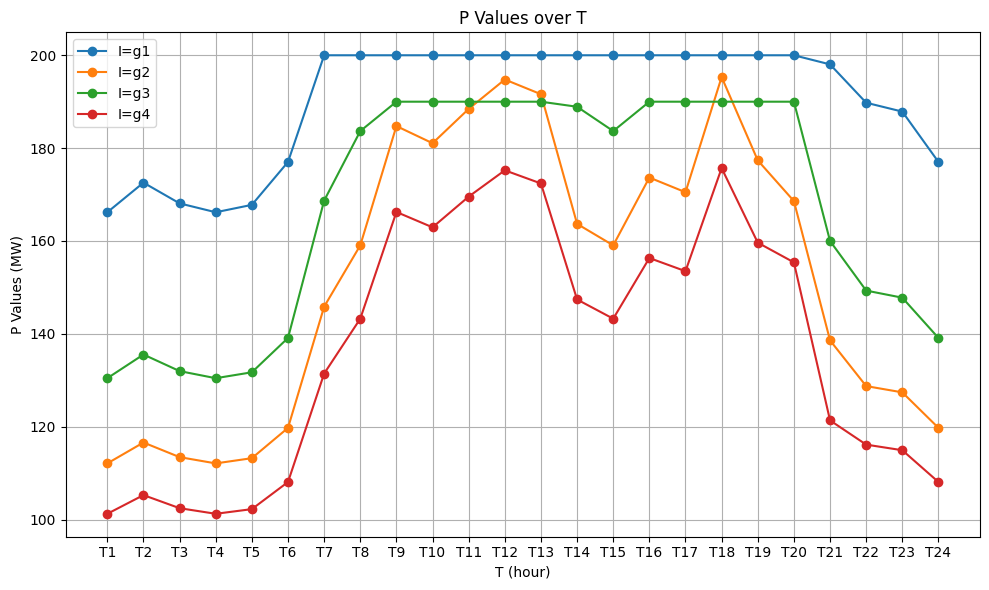

In [14]:
plt.figure(figsize=(10,6))
for i in model.I:
    PI_values = [value(model.P[i, t]) for t in model.T]
    plt.plot(list(model.T), PI_values, marker='o', label=f'I={i}')
plt.xlabel('T (hour)')
plt.ylabel('P Values (MW)')
plt.title('P Values over T')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()